# Kolmogorov-Arnold Network with B-Spline approximation
We demonstrate a Kolmogorov-Arnold network whose learned activation functions are B-Spline functions composed onto
rational normalization. This is somewhat similar to the original KAN paper.

In [1]:
import torch
from torch import nn
import torchcurves as tc
import matplotlib.pyplot as plt

## Define regression function

In [2]:
def func(xs):
    pole_1 = torch.tensor(0-2j)
    pole_2 = torch.tensor(0-1j)
    cresult = 10 / (xs[:, 0] + 2 * xs[:, 1] - pole_1) - 2 / (2 * xs[:, 0] - xs[:, 1] - pole_2)
    return cresult.abs()

In [3]:
n = 100
xs = torch.linspace(-3, 3, n)
ys = torch.linspace(-3, 3, n)
grid = torch.cartesian_prod(xs, ys)
zs = func(grid)

In [4]:
ax = plt.figure().add_subplot(projection='3d')
grid_x = grid[:, 0].reshape(n, n)
grid_y = grid[:, 1].reshape(n, n)
plot_z = zs.reshape(n, n)
ax.plot_surface(grid_x, grid_y, plot_z)

## Generate training data

In [16]:
n_samples = 1000
sigma = 0.3
X = torch.randn(n_samples, 2)
y = func(X) + sigma * torch.randn(n_samples)

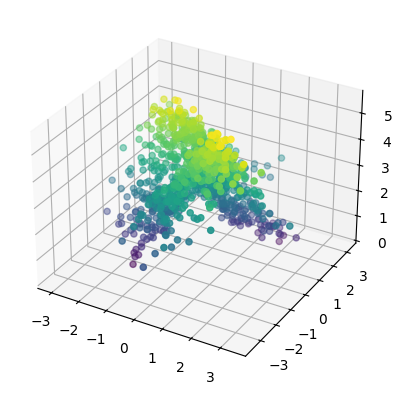

In [17]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], y, c=y)

## Define and train the KAN

In [77]:
input_dim = 2
intermediate_dim = 5
knots = 10

kan = nn.Sequential(
    # layer 1
    tc.BSplineCurve(input_dim, intermediate_dim, knots_config=knots, normalize_fn='rational'),
    tc.Sum(dim=-2),
    # layer 2
    tc.BSplineCurve(intermediate_dim, intermediate_dim, knots_config=knots, normalize_fn='rational'),
    tc.Sum(dim=-2),
    # layer 3
    tc.BSplineCurve(intermediate_dim, 1, knots_config=knots, normalize_fn='rational'),
    tc.Sum(dim=-2),
)

In [78]:
example_data = torch.tensor([[-5, 3], [3, 2], [1, 3]])
output = kan(example_data)
print(output.shape)

torch.Size([3, 1])


In [79]:
n_epochs = 100
batch_size = 32
lr = 5e-3
print_every = 10

dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batch_size, shuffle=True)
optim = torch.optim.Adam(kan.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, 1 + n_epochs):
    epoch_loss = 0.
    for Xb, yb in dl:
        pred = kan(Xb)
        cost = criterion(pred.squeeze(), yb)

        optim.zero_grad()
        cost.backward()
        optim.step()

        epoch_loss += cost * Xb.shape[0]

    epoch_loss /= n_samples
    eval_loss = criterion(kan(grid).squeeze(), func(grid))

    if epoch == n_epochs or epoch % print_every == 0:
        print(f'Epoch {epoch}: train loss = {epoch_loss:.3f}, eval_loss = {eval_loss:.3f}')

Epoch 10: train loss = 0.150, eval_loss = 0.189
Epoch 20: train loss = 0.109, eval_loss = 0.110
Epoch 30: train loss = 0.100, eval_loss = 0.084
Epoch 40: train loss = 0.092, eval_loss = 0.068
Epoch 50: train loss = 0.095, eval_loss = 0.071
Epoch 60: train loss = 0.090, eval_loss = 0.066
Epoch 70: train loss = 0.094, eval_loss = 0.063
Epoch 80: train loss = 0.090, eval_loss = 0.079
Epoch 90: train loss = 0.087, eval_loss = 0.072
Epoch 100: train loss = 0.086, eval_loss = 0.065


## Plot the network and the true function, side by side

In [80]:
with torch.no_grad():
    kan_z = kan(grid).reshape(n, n)

In [82]:
fig = plt.figure(figsize=(10, 4))
ax_left = fig.add_subplot(1, 2, 1, projection='3d')
ax_right = fig.add_subplot(1, 2, 2, projection='3d')

ax_left.set_title('True function')
ax_left.plot_surface(grid_x, grid_y, plot_z)

ax_right.set_title('Spline-Rational KAN')
ax_right.plot_surface(grid_x, grid_y, kan_z)

plt.show()